# Structural Break Detection: Chow Test
- Chow (1960): [Tests of Equality Between Sets of Coefficients in Two Linear Regressions](https://www.semanticscholar.org/paper/Tests-of-equality-between-sets-of-coefficients-in-Chow/0f70219160c8ad2f9db02e226d3f7d7320e729b8?p2df)
- References
    - https://ssc.wisc.edu/~bhansen/crete/crete5.pdf
    - https://en.wikipedia.org/wiki/Gregory_Chow
    - https://en.wikipedia.org/wiki/Chow_test

In [1]:
%%capture

!pip install --upgrade pandas-datareader
!pip install ffn yfinance

In [2]:
import numpy as np
import scipy
import statsmodels.api as sm
import ffn
import yfinance as yf
import pandas as pd
import datetime

import matplotlib.pyplot as plt 

params = {'legend.fontsize': 'x-large',
      'figure.figsize': (12, 6),
      'axes.labelsize': 'x-large',
      'axes.titlesize': 'x-large',
      'xtick.labelsize': 'x-large',
      'ytick.labelsize': 'x-large',
      'lines.linewidth': 2}

plt.rcParams.update(params)

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Example 1: Known Date

In [3]:
ticker = "2330"
tbl = pd.DataFrame(yf.download("{0}.tw".format(ticker), period = "2y")["Adj Close"])
tbl.columns = ["{0}tw".format(ticker)]
tbl

[*********************100%***********************]  1 of 1 completed


,2330tw
Date,
2019-07-02,236.612778
2019-07-03,230.436127
2019-07-04,231.861511
2019-07-05,230.911270
2019-07-08,230.436127
...,...
2021-06-28,590.000000
2021-06-29,595.000000
2021-06-30,595.000000


In [4]:
def chowtest(y, idx, significance_level = 0.05):

    from scipy.stats import f

    x = np.linspace(0, 1, len(y))
    X = sm.add_constant(x)
    model_all = sm.OLS(y, X)
    result_all = model_all.fit()

    k = 2
    N1 = idx
    N2 = len(y) - N1

    x = np.linspace(0, 1, N1)
    X = sm.add_constant(x)
    model_before = sm.OLS(y[0:idx], X)
    result_before = model_before.fit()

    x = np.linspace(0, 1, N2)
    X = sm.add_constant(x)
    model_after = sm.OLS(y[idx:], X)
    result_after = model_after.fit()

    rss = result_all.rsquared.sum()
    rss1 = result_before.rsquared.sum()
    rss2 = result_after.rsquared.sum()
    numerator = (rss - (rss1 + rss2)) / k
    denominator = (rss1 + rss2) / (N1 + N2 - 2 * k)
    Chow_Stat = numerator / denominator

    if np.isnan(rss):
        raise Exception("rss is nan.")
    if np.isnan(rss1):
        raise Exception("rss1 is nan.")
    if np.isnan(rss2):
        raise Exception("rss2 is nan.")

    xx = f.cdf(Chow_Stat, dfn = 2, dfd = (N1 + N2 - 2 * k))
    
    if np.isnan(xx):
        raise Exception("(1 - p-value) is nan.")

    p_value = 1 - xx
    return Chow_Stat, p_value, result_all, result_before, result_after

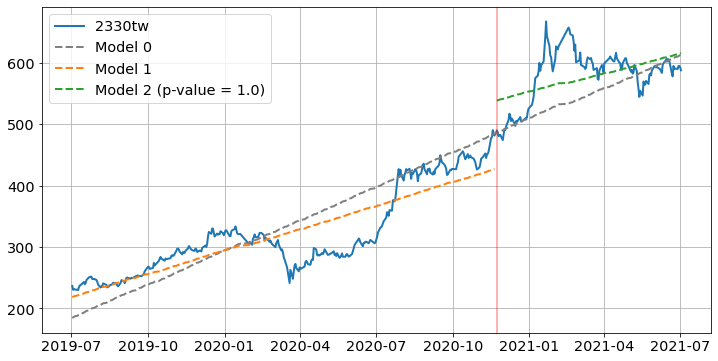

In [ ]:
y = tbl["{0}tw".format(ticker)]

split_idx = round(len(y) * 0.70)
chow_stat, pvalue, model0, model1, model2 = chowtest(y, split_idx)

plt.figure(figsize = (12, 6))
plt.plot(y.index, y.values)
plt.grid(True)

beta = model0.params
x = np.linspace(0, 1, len(y))
X = sm.add_constant(x)
y_est = X.dot(beta)
plt.plot(y.index, y_est, "--", color = "gray")

beta = model1.params
x = np.linspace(0, 1, split_idx)
X = sm.add_constant(x)
y_est = X.dot(beta)
plt.plot(y.index[0:split_idx], y_est, "--")

beta = model2.params
x = np.linspace(0, 1, len(y) - split_idx)
X = sm.add_constant(x)
y_est = X.dot(beta)
plt.plot(y.index[split_idx:], y_est, "--")

plt.legend(["{0}".format(tbl.columns[0], y.index[0].strftime("%Y-%m-%d"), y.index[-1].strftime("%Y-%m-%d")), "Model 0", "Model 1", "Model 2 (p-value = {0})".format(round(pvalue, 2))])
plt.axvline(y.index[split_idx], lw = 2, color = "r", alpha = 0.3)
plt.show()

## Example 2: Unknown Date

In [ ]:
low = round(len(y) * 0.15)
high = round(len(y) * 0.85)

tbl2 = tbl.copy()
tbl2["chow"] = 0
tbl2["chow_p"] = 0
for idx in range(low, high + 1):
    chow_stat, pvalue, _, _, _ = chowtest(tbl2["{0}tw".format(ticker)], idx)
    tbl2["chow"][idx] = chow_stat
    tbl2["chow_p"][idx] = pvalue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


2020-12-23 00:00:00


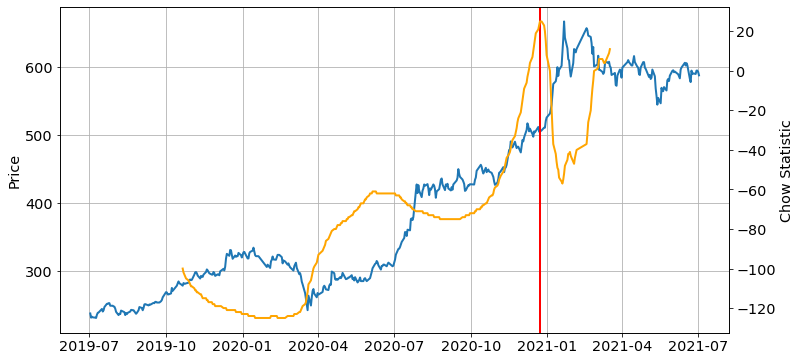

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(y)
ax.set_ylabel("Price")
plt.grid(True)

ax2 = ax.twinx()
ax2.plot(tbl2.index[low : high + 1], tbl2["chow"][low : high + 1], color = "orange")
ax2.set_ylabel("Chow Statistic")

idx = np.argmax(tbl2["chow"])
print(tbl2.index[idx])
ax.axvline(y.index[idx], color = "red")